# 状態空間モデルによる欠損値補完

ローカルレベルトレンドモデルによる欠損値補完

## データ
- N : 全区間のデータ数
- M : 観測データ数
- L : 欠損データ数
- Y : 観測データ
- missing_index : 欠損データのインデックス

## パラメータ
- mu : 状態
- sigma_mu : システムモデル分散
- sigma_Y : 観測モデル分散

## モデル
- $\mu_{t} \sim Normal(\mu_{t-1},\sigma_{\mu}) $

- $Y_{t} \sim Normal(\mu_{t},\sigma_{Y}) $

In [1]:
%matplotlib inline
import pystan
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (20, 12)

In [114]:
stan_code = """
data {
    int N;
    int L;
    vector[N] Y;
    int missing_index[L];
}

parameters {
    vector[N] mu;
    real<lower=0> s_mu;
    real<lower=0> s_Y;
}

model {
    int cnt;
    cnt = 1;
    
    mu[3:N] ~ normal(2*mu[2:(N-1)]-mu[1:(N-2)],s_mu);

    for(i in 1:N){
        if(missing_index[cnt] ==i){
            if(cnt < L)
                cnt = cnt + 1;
        }else{
            Y[i] ~ normal(mu[i],s_Y);
        }
    }
}

generated quantities{
    vector[L] missing_values;
    for(i in 1:L){
        missing_values[i] = normal_rng(mu[missing_index[i]],s_Y);
    }
}
"""

In [126]:
N=50
y=np.linspace(0,10,N) + np.random.normal(0,1,size=N)

missing_index = np.array(range(6,12))

stan_dat = {
    'N': len(y),
    'L': len(missing_index),
    'Y': y,
    'missing_index' : missing_index + 1
}
fit = pystan.stan(model_code = stan_code, data = stan_dat, iter = 2500, chains = 4)

In [127]:
fit

Inference for Stan model: anon_model_71cf5865f46efacdaf9525e9f308c1cd.
4 chains, each with iter=2500; warmup=1250; thin=1; 
post-warmup draws per chain=1250, total post-warmup draws=5000.

                    mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu[0]               0.83    0.03   0.59  -0.28   0.43   0.81    1.2   2.07    446   1.01
mu[1]               0.94    0.02   0.51  -0.04    0.6   0.94   1.28   1.98    711   1.01
mu[2]               1.06    0.02   0.46   0.17   0.75   1.06   1.36   1.98    763   1.01
mu[3]               1.18    0.02   0.43   0.35   0.89   1.18   1.47   2.03    788    1.0
mu[4]               1.31    0.01   0.41   0.51   1.03   1.31   1.57   2.11    794    1.0
mu[5]               1.44    0.01    0.4   0.63   1.18   1.45   1.71   2.21    779    1.0
mu[6]               1.58    0.01   0.41   0.74   1.32   1.59   1.84   2.33    738    1.0
mu[7]               1.71    0.02   0.41   0.85   1.46   1.74   1.99   2.45    525   1.01
mu[8]     

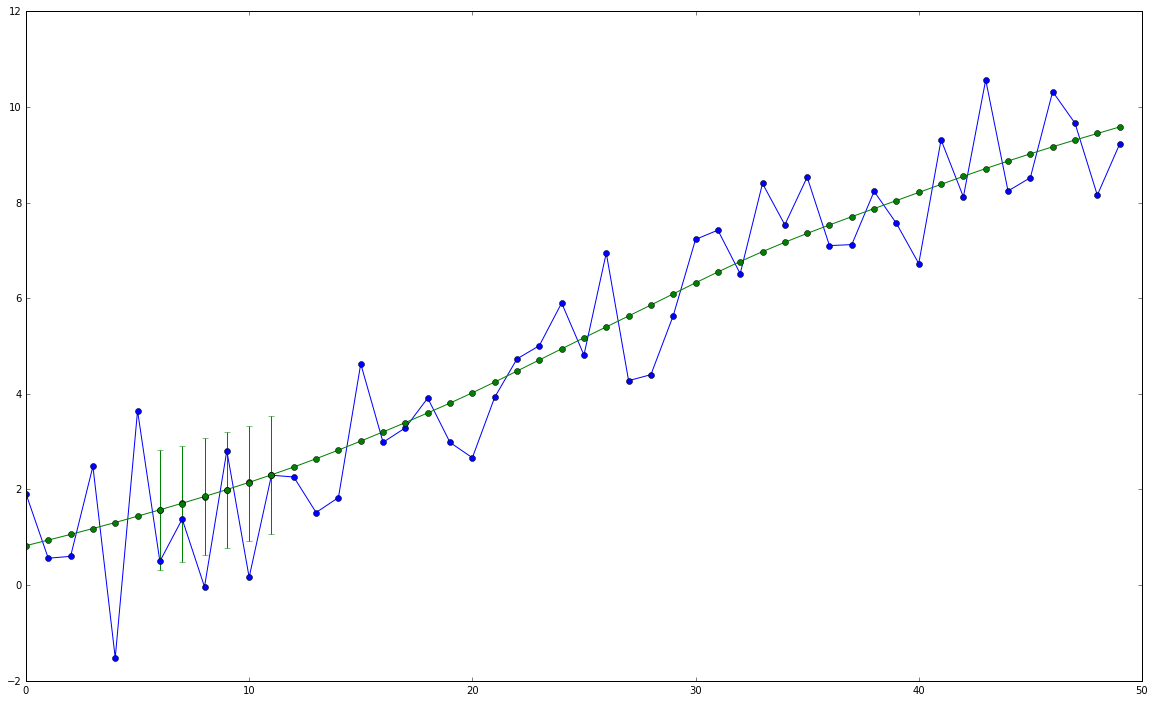

In [128]:
ms=fit.extract()

plt.plot(y,"bo-")
plt.plot(np.mean(ms["mu"],axis=0),"go-")

mv_mu=np.mean(ms["missing_values"] ,axis=0)
mv_std=np.std(ms["missing_values"] ,axis=0)

for i,ix in enumerate(missing_index):
    plt.errorbar(ix,mv_mu[i],yerr=mv_std[i],fmt='ro',ecolor='g',color="g")